<a href="https://colab.research.google.com/github/davidnoone/GEOPHYS_NOTEBOOKS/blob/main/ENVPHYS200_waether_mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ENVPHYS 200: Weather mapping lab


We are interested in the weather contitions in the New Zealand region for the date of 11 February 2023.



###Learning goals
* (Hydrostatic) Similarity of height at constant pressure, and pressure at constant height
* (Hydrostatic/hypsometric) Relationship between geopotential and temperature
* (Geostrophic) Winds and pressure gradients


###Python goals
* Explore use of gridded 2d data in python (using numpy)
* Plotting maps of 2d data (contour and contourf)
* Plotted maps of 2d vector fields (quiver)
* Intro to map projections, geographic coordinates.




In [6]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

try:
    import netCDF4 as ncdf
except:
    print('NetCDF needs to be installed: this will take a few moments')
    !pip install netCDF4
    import netCDF4 as ncdf

try:
  import cartopy.crs as ccrs
except:
  print('cartopy needs to be installed: this will take a few moments')
  !pip install cartopy
  !pip uninstall shapely -y
  !pip install shapely --no-binary shapely
  import cartopy.crs as ccrs


# Download a data file from github, if it doesn't exist
##!test ! -f ERA5_pr_2021-01-01.nc && wget 'https://raw.github.com/davidnoone/GEOPHYS_NOTEBOOKS/main/data/ERA5_pr_2021-01-01.nc'


In [7]:
# Some physical constants which we will need later
gravity = 9.81            # acceleration due to gravity [m/s]
rearth  = 6371000.        # radius of the earth [m]
omega   = 7.2921159e-5    # Rotation rate of earth (2 pi radians/day)


def calculate_gradient(lons,lats,fld):
    """ Uses a finite difference method to compute grradients in x and y
        of some 2d field: fld(y,x), returns dfdx and dfdy
        Assumes "x" is longitudes, and "y" is latitudes
        Assume grid has constant spacing.
    """
    # calculate distance, in meters, between grid points
    dx = rearth*np.radians((lons[2] - lons[1]))
    dy = rearth*np.radians((lats[2] - lats[1]))
    coslat = np.cos(np.radians(lats))

    # gradient in "x": use "roll" to account for periodic edges
    dfdx = (np.roll(fld, -1) - np.roll(fld))/(2*dx*coslat)

    # gradent in "y"
    dfdy = np.gradient(fld,axis=1)/(2*dy)

    return dfdx, dfdy


##Data
We will use data from the ECMWF 5th Reanalysis ("ERA5"). This data set is a comprehensive global 3d depiction of the atmosphere that spans from 1940 until today! It has developed in a way similar to opperational weather forecasts, by blending observations (from baloons, satellies, surface sites and other) with a state-of-the-art weather model. As a result a large number of variables are available for analysis.

We will focus on...
* Mean sea level pressure (MSLP)
* Geopotential height at 1000 and 500 hPa (Z100 and Z500)
* Precipitable water (PWTR)

Each of these variables exists on a latitude x longitude grid, which has a spacing of 0.25 degrees.

The original data comes in a data format called NetCDF, which is a very common data format for large atmospheric datasets. Python has a library that can read these data.

In [13]:
# Read in the data

with ncdf.Dataset('ERA_prl_20230211.nc','r') as ncfile:    # open the file and read the data...
  lons  = ncfile.variables['longitude'][:]    # read the longitudes
  lats  = ncfile.variables['latitude'][:]     # read the latitudes
  levs  = ncfile.variables['level'][:]        # read the pressre level
  z500  = ncfile.variables['z'][0,1,:,:]      # read the 500 hPa height
  z1000 = ncfile.variables['z'][0,0,:,:]      # read the 1000 hPa height

with ncdf.Dataset('ERA_sfc_20230211.nc','r') as ncfile:    # open the file and read the data...
#  psfc  = ncfile.variables['msl'][0,:,:]      # read the surface pressure
  mslp  = ncfile.variables['msl'][0,:,:]      # read the mean sea level pressure
  pwtr  = ncfile.variables['tcw'][0,:,:]      # read the mean sea level pressure

mslp = mslp/100       # convert to hPa

nlon = len(lons)
nlat = len(lats)
nhalf = int(nlon/2)


# Explort the



In [9]:
print("Shape of lats:",np.shape(lats))
print("Shape of lons:",np.shape(lons))
print("Shape of mslp:",np.shape(mslp))

print('Latitudes:',lats)
print('Longitudes:',lons)

Shape of lats: (181,)
Shape of lons: (360,)
Shape of mslp: (181, 360)
Latitudes: [ 90.  89.  88.  87.  86.  85.  84.  83.  82.  81.  80.  79.  78.  77.
  76.  75.  74.  73.  72.  71.  70.  69.  68.  67.  66.  65.  64.  63.
  62.  61.  60.  59.  58.  57.  56.  55.  54.  53.  52.  51.  50.  49.
  48.  47.  46.  45.  44.  43.  42.  41.  40.  39.  38.  37.  36.  35.
  34.  33.  32.  31.  30.  29.  28.  27.  26.  25.  24.  23.  22.  21.
  20.  19.  18.  17.  16.  15.  14.  13.  12.  11.  10.   9.   8.   7.
   6.   5.   4.   3.   2.   1.   0.  -1.  -2.  -3.  -4.  -5.  -6.  -7.
  -8.  -9. -10. -11. -12. -13. -14. -15. -16. -17. -18. -19. -20. -21.
 -22. -23. -24. -25. -26. -27. -28. -29. -30. -31. -32. -33. -34. -35.
 -36. -37. -38. -39. -40. -41. -42. -43. -44. -45. -46. -47. -48. -49.
 -50. -51. -52. -53. -54. -55. -56. -57. -58. -59. -60. -61. -62. -63.
 -64. -65. -66. -67. -68. -69. -70. -71. -72. -73. -74. -75. -76. -77.
 -78. -79. -80. -81. -82. -83. -84. -85. -86. -87. -88. -89. -90.]


# Plotting the data

To visualize the data, we wish to make a contour plot.
One complexity is that we wish the coordinates to be understood as geographic coodinaes.


---
### Task (a) Make a contour plot of each of the four quantities: MSLP, Z1000, Z500 and PWTR
_The contour plots should have labels and a title that describes what each plot is._

You will use the "contour" and "contourf" functions.
Your figures can have a title.

You may also wish to explore different contour levels, adding a colorbar, adding line labels, and possibly changing the colors!

See documentation and examples at:
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html

Particularly useful key words are "levels", "cmap", "colors"



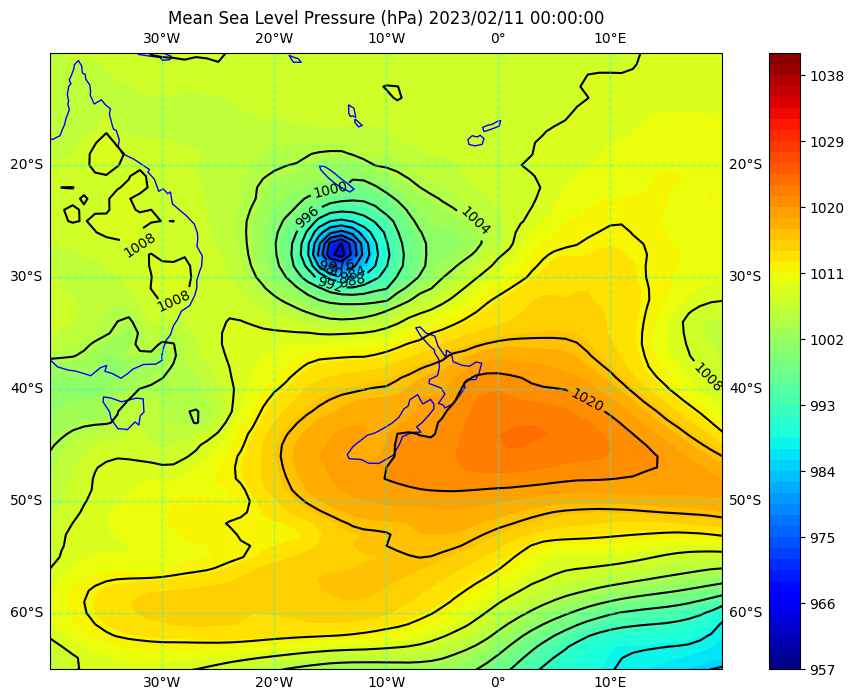

In [27]:
# Example: plotting mean sea level

extent = [140, 200, -65, -10]
proj_grid = ccrs.PlateCarree(180)      # Map projection with 180 is the central longitude
proj_data = ccrs.PlateCarree(0)      # Data has "longitude", relative to 0 E.


fig = plt.figure(figsize=[12,8])                  # Create a figure

ax = plt.axes(projection=proj_grid)
ax.set_extent(extent,proj_data)
ax.set_title("Mean Sea Level Pressure (hPa) 2023/02/11 00:00:00")

# Shaded contours for temperature
levels = 800 + 2*np.arange(100)       # set values for contour fill
cf = plt.contourf(lons, lats, mslp,60, cmap='jet',transform=proj_data)

## Add a color bar
plt.colorbar(cf)

# Overlay contour lines
levels = 800 + 4*np.arange(100)       # set values for contour lines
cl = plt.contour(lons, lats, mslp, levels, colors='black',transform=proj_data)

# Add contour line liables
ax.clabel(cl, cl.levels, inline=True, fontsize=10)


# Add costlines
ax.coastlines(color='blue')

# Add grid lines
ax.gridlines(crs=proj_grid, linewidth=1, color='cyan',
    draw_labels=True, alpha=0.5, linestyle='--')



In [ ]:
# Your plots for Z1000, Z500 and PWTR here
# (It is recommended you use the example above, and adapt it.)


# MSLP




# Z1000




# Z500


---
###Task (b)	Describe the visual similarity between MSLP and Z1000.
_Making reference to the hydrostatic equation, give an explanation for your answer._



[Click to type answer here]

---
###Task (c) Make a plot of the difference in the height between 500 hPa – 1000 hPa

In [ ]:
# Your plot of thickness


---
###Task (d): Explain why the 1000-500 hPa thickness is a good indicator of average tropospheric temperature.
_Making reference to the hydrostatic equation in your answer. You may wish to write down the equation_

[Click to type your answer]


---
###Task (e): Calculate and plot the average lower troposphere temperature in units of Kelvin.

In [ ]:
# Your plot here

---
### Task (f) Calculate the geostrophic wind at 500 hPa in units of m/s, and plot it.

First you will need to calculate the "u" and "v" wind components, using the geostrophic balance equations.
Once you have these, you can use the "quiver" function to construct the a plot of the little vectors.

You can calculate the wind speed in the usual way.

$$
|V| = \sqrt{(u^2 + v^2)}
$$

Aim to produce a plot similar to the one from part one of the assignment: showing wind speed in color shading, and then direction as little arrow.

You might also find it helpful to overlay a contour lines for the Z500.



In [ ]:
# Calculate the coriolis parameter: f = 2 * omega * sin(latitude)
fcor = 2.0*omega*np.sin(np.radians(lats))


# Calculate the pressure gradient in "x" and "y".
dzdx, dzdy = calculate_gradient(lons,lats,z500)


# Calculate the geostrophic wind components
ugeo = [something here]
vgeo = [something here]


# Calculate the geostriophic wind speed
vspeed = np.sqrt(ugeo*ugeo + vgeo*vgeo)



# PLOT:
fig = plt.figure()

# Contour fill for speed
plt.contourf(lons,lats,vspeed)

# "quiver" for vectors:
plt.quiver(lons,lats,ugeo,vgeo)


# Contour lines for Z500
plt.contour(lons,lats,vs)





---
### Task (g): Examining your diagrams, describe the expected influence of advection on the temperature and water content near Auckland.

[Double click to enter your answer]

---
### Task (h): Describe the weather conditions. What do you expect the weather to be like in the Auckland region in the day or two which follows.

Make reference to the figures, and explain your reasoning.

[Double click to type your answer]

---
# Outcome

Having reached the end, you have now learned to be able to read, visualize, and perform calulations with 2d geophysical datasets. Datasets like these are used in opperational and research applications in many fields of earth science, including weather and climate modeling.

Here, you've been able to combined oberservations, with derived calulations for temperature and wind, that together allow you to offer an analysis of current weather conditions, and how the atmospheric circulation on this day is likely to change.


In [ ]:
#